In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import os
import requests
import csv
from decimal import Decimal
import seaborn as sns
import numpy as np
import json
from brownie import *
from web3 import Web3
from bs4 import BeautifulSoup

In [2]:
# load env file - etherscan & infura api (create .env file in same directory)

"""
WEB3_INFURA_PROJECT_ID=YOUR_API_TOKEN
ETHERSCAN_TOKEN=YOUR_API_TOKEN
"""

%load_ext dotenv
%dotenv

In [3]:
os.chdir(r"C:\Users\tunc-\Desktop\uni\04_FS23\seminar\03_code") # use your root

In [4]:
tally_api_key = "xxx" # tally.xyz API Key
uni_token_contract_address = "0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984" # Uniswap UNI token contract address
uni_governorbravo_contract_address = "0x408ED6354d4973f66138C91495F2f2FCbd8724C3" # Uni Governor Bravo address
uni_timelock_contract_address = "0x1a9C8182C09F50C8318d769245beA52c32BE35BC" # Uni Governor Bravo address

## Files Preparation

#### Helper functions for GraphQL tally.xyz API

In [5]:
def fetch_proposal_data(governor_address):
    url = "https://api.tally.xyz/query"

    headers = {
        "Api-key": tally_api_key,
        "Content-Type": "application/json"
    }

    query = '''
    query Governors($chainIds: [ChainID!], $addresses: [Address!], $ids: [AccountID!], $includeInactive: Boolean, $pagination: Pagination, $sort: GovernorSort) {
      governors(chainIds: $chainIds, addresses: $addresses, ids: $ids, includeInactive: $includeInactive, pagination: $pagination, sort: $sort) {
        id
        type
        lastIndexedBlock {
          id
          number
          timestamp
        }
        proposals {
          id
          proposer {
            address
            ens
          }
          start {
            number
            timestamp
          }
          end {
            number
            timestamp
          }
          votes {
            id
            weight
            support
            transaction {
              block {
                timestamp
              }
            }
          }
        }
        quorum
        name
      }
    }
    '''

    variables = {
        "chainIds": ["eip155:1"],
        "addresses": [governor_address],
        "ids": [f"eip155:1:{governor_address}"],
        "includeInactive": True,
        "pagination": {"limit": 20, "offset": 0},
        "sort": {"field": "TOTAL_PROPOSALS", "order": "ASC"}
    }

    payload = {
        "query": query,
        "variables": variables
    }

    response = requests.post(url, headers=headers, data=json.dumps(payload))

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed with status code {response.status_code}")

In [6]:
def fetch_delegates_addresses(governor_address):
    url = "https://api.tally.xyz/query"

    headers = {
        "Api-key": tally_api_key,
        "Content-Type": "application/json"
    }

    query = '''
    query Governors($chainIds: [ChainID!], $addresses: [Address!], $ids: [AccountID!]) {
      governors(chainIds: $chainIds, addresses: $addresses, ids: $ids) {
        id
        type
        delegates {
          account {
            address
          }
        }
        name
      }
    }
    '''

    variables = {
        "chainIds": ["eip155:1"],
        "addresses": [governor_address],
        "ids": [f"eip155:1:{governor_address}"]
    }

    payload = {
        "query": query,
        "variables": variables
    }

    response = requests.post(url, headers=headers, data=json.dumps(payload))

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed with status code {response.status_code}")

#### Helper functions to create CSV files

In [7]:
def create_csv_from_proposal_response_data(data: str, output_filename: str):
    proposals = data["data"]["governors"][0]["proposals"]

    with open(output_filename, "w", newline="") as csvfile:
        fieldnames = [
            "governorId",
            "type",
            "proposalId",
            "proposerAddress",
            "proposerEns",
            "proposalStart",
            "proposalEnd",
            "proposalStartBlock",
            "proposalEndBlock",
            "votesId",
            "votesWeight",
            "votesSupport",
            "votesTimestamp",
            "quorum",
            "name",
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        governor = data["data"]["governors"][0]
        for proposal in proposals:
            if len(proposal["votes"]) > 1:
                for vote in proposal["votes"]:
                    row = {
                        "governorId": governor["id"],
                        "type": governor["type"],
                        "proposalId": proposal["id"],
                        "proposerAddress": proposal["proposer"]["address"],
                        "proposerEns": proposal["proposer"]["ens"],
                        "proposalStart": proposal["start"]["timestamp"],
                        "proposalEnd": proposal["end"]["timestamp"],
                        "proposalStartBlock": proposal["start"]["number"],
                        "proposalEndBlock": proposal["end"]["number"],
                        "votesId": vote["id"],
                        "votesWeight": vote["weight"],
                        "votesSupport": vote["support"],
                        "votesTimestamp": vote["transaction"]["block"]["timestamp"],
                        "quorum": governor["quorum"],
                        "name": governor["name"],
                    }
                    writer.writerow(row)

In [8]:
def create_csv_from_delegates_response_data(data: str, output_filename: str):
    delegates = data["data"]["governors"][0]["delegates"]

    with open(output_filename, "w", newline="") as csvfile:
        fieldnames = [
            "governorId",
            "type",
            "address",
            "name",
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        governor = data["data"]["governors"][0]
        for delegate in delegates:
            row = {
                "governorId": governor["id"],
                "type": governor["type"],
                "address": delegate["account"]["address"],
                "name": governor["name"],
            }
            writer.writerow(row)

#### Fetch proposals and delegates addresses

In [10]:
# Fetch Uniswap Proposals & save it as CSV file
data = fetch_proposal_data(uni_governorbravo_contract_address)
create_csv_from_proposal_response_data(data, "data/Uniswap_GOVERNORBRAVO_proposals.csv")

In [11]:
# Fetch Uniswap Delegates Addresses & save it as CSV file
data = fetch_delegates_addresses(uni_governorbravo_contract_address)
create_csv_from_delegates_response_data(data, "data/Uniswap_UNITOKEN_delegates.csv")

#### Connect to mainnet using web3 and brownie

In [5]:
# connect to mainnet
if network.is_connected():
    network.disconnect()
network.connect("mainnet")
print("Connected to:", network.show_active())

Connected to: mainnet


In [6]:
# Load the Uni Token contract!
Uni = Contract.from_explorer(uni_token_contract_address)

Fetching source of 0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984 from api.etherscan.io...


In [7]:
# Load the UNI Token Contract as web3 contract object.
WUni = web3.eth.contract(Uni.address, abi=Uni.abi)

In [8]:
# Read the CSV file of Uniswap Token delegatees
df_delegates_raw = pd.read_csv("./data/Uniswap_UNITOKEN_delegates.csv")

In [9]:
print("Number of delegatees: ",len(df_delegates_raw))

Number of delegatees:  29316


#### Fetch voting power and token balance for delegates addresses

In [ ]:
# Iterate over the delegatees addresses and fetch current delegated voting power, token balance

# Initialize an empty list to store the data
data_delegates = []

# Initialize a counter
counter = 1

for address in df_delegates_raw['address']:
    voting_power = Uni.getCurrentVotes(address)
    tokens_owned = Uni.balanceOf(address)
    data_delegates.append([address, voting_power, tokens_owned])
    print("Address", address)

    counter += 1

    # If the counter is a multiple of 100, save a new CSV file
    if counter % 100 == 0:
        # Create a new DataFrame with the fetched data
        df_delegates_chunk = pd.DataFrame(data_delegates, columns=['address', 'votingPower', 'tokensOwned'])
        df_delegates_chunk.to_csv(f'data/delegatees_balance/delegates_{counter}.csv', index=False)
        
        # Clear the list for the next chunk
        data_delegates.clear()

        print(f"Saved {counter} addresses to CSV.")

# Save remaining data (if any) to a new CSV file
if data_delegates:
    df_delegates_chunk = pd.DataFrame(data_delegates, columns=['address', 'votingPower', 'tokensOwned'])
    df_delegates_chunk.to_csv(f'data/delegatees_balance/delegates_{counter}.csv', index=False)

In [11]:
# create one CSV file for all the chunks

# Create an empty list to store the DataFrames
dfs = []

# Specify the directory where the CSV files are
directory = 'data/delegatees_balance/'

# Iterate over the CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory, filename))

        # Add the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames in the list into one DataFrame
df_combined = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
df_combined.to_csv('data/Uniswap_UNITOKEN_delegates_balance.csv', index=False)

#### Fetch event data for top delegates addresses (according to voting power)

In [9]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('data/Uniswap_UNITOKEN_delegates_balance.csv')

# Create a temporary column 'votingPower_float' with 'votingPower' converted to float
df_raw['votingPower_float'] = df_raw['votingPower'].astype(float)

# Filter the delegates with more than 1 million voting power
top_delegates = df_raw[df_raw['votingPower_float'] > 1e6 * 1e18].copy()  # > 1 Mil

# Filter the delegates with more than 1 million voting power
up_delegates = df_raw[df_raw['votingPower_float'] > 5e6 * 1e18].copy()  # > 5 Mil

# Filter for 2.5 million to 5 million voting power
middle_delegates = df_raw[(df_raw['votingPower_float'] > 2.5e6 * 1e18) & (df_raw['votingPower_float'] <= 5e6 * 1e18)].copy()  # 2.5 Mil - 5 Mil

# Filter for 1 million to 2.5 million voting power
low_delegates = df_raw[(df_raw['votingPower_float'] > 1e6 * 1e18) & (df_raw['votingPower_float'] <= 2.5e6 * 1e18)].copy()  # 1 Mil - 2.5 Mil

# Drop the temporary column from the original and the new DataFrame
df_raw.drop('votingPower_float', axis=1, inplace=True)
top_delegates.drop('votingPower_float', axis=1, inplace=True)
up_delegates.drop('votingPower_float', axis=1, inplace=True)
middle_delegates.drop('votingPower_float', axis=1, inplace=True)
low_delegates.drop('votingPower_float', axis=1, inplace=True)

In [10]:
print("Number of addresses that have more than 1 million delegated voting power: ", len(top_delegates))

Number of addresses that have more than 1 million delegated voting power:  44


In [ ]:
# get events for top_delegates 
# Iterate over top_delegates addresses and fetch events for every checkpoint, to examine delegation behaviour later on

# DVC: DelegateVotesChanged Event - previousBalance, newBalance, amount
# DC: DelegateChanged Event - delegator, fromDelegate, toDelegate
# T: Transfer Event - transferFrom, transferTo

# Initialize an empty list to store the data
data_delegates = []

counter = 0

for index, row in top_delegates.iterrows():
    voting_power = row["votingPower"]
    tokens_owned = row["tokensOwned"]
    address = row["address"]
    num_checkpoints = Uni.numCheckpoints(address)
    
    for checkpoint_index in range(num_checkpoints):
        checkpoint = Uni.checkpoints(address, checkpoint_index)
        block_number = checkpoint['fromBlock']
        
        # Initialize default values
        delegator = fromDelegate = toDelegate = previousBalance = newBalance = transfer_from = transfer_to = None
        
        # Create a filter for DelegateChanged events in the block
        filter_DelegateChanged = Uni.events.DelegateChanged.createFilter(fromBlock=block_number, toBlock=block_number)
        logs_DelegateChanged = filter_DelegateChanged.get_all_entries()
        logs_DelegateChanged = [log for log in logs_DelegateChanged if log.args.fromDelegate == address or log.args.toDelegate == address]

        # DelegateChanged Event could be empty, because DelegateVotesChanged Event is emited trough transfer and mint functions.
        if logs_DelegateChanged:  # If there are any DelegateChanged events for the address in the block
            last_log = logs_DelegateChanged[-1]  # Take the last event in the block
            from_delegate = last_log.args.fromDelegate
            to_delegate = last_log.args.toDelegate
            delegator = last_log.args.delegator
        else:
            from_delegate = None
            to_delegate = None
            delegator = None

        # Create a filter for DelegateVotesChanged events for the address in the block (also called trough mint and transfer functions)
        filter_DelegateVotesChanged = Uni.events.DelegateVotesChanged.createFilter(fromBlock=block_number, toBlock=block_number, argument_filters={'delegate': address})
        logs_DelegateVotesChanged = filter_DelegateVotesChanged.get_all_entries()

        if logs_DelegateVotesChanged:  # If there are any DelegateVotesChanged events for the address in the block
            last_log = logs_DelegateVotesChanged[-1]  # Take the last event in the block
            previous_balance = last_log["args"]["previousBalance"]
            new_balance = last_log["args"]["newBalance"]
            difference = new_balance - previous_balance
        else:
            previous_balance = None
            new_balance = None
            difference = None
            
        # Create a filter for Transfer events in the block
        filter_Transfer = Uni.events.Transfer.createFilter(fromBlock=block_number, toBlock=block_number)
        logs_Transfer = filter_Transfer.get_all_entries()
        logs_Transfer = [log for log in logs_Transfer if log.args.amount == abs(difference)]

        # Transfer Event could be empty
        if logs_Transfer:
            last_log = logs_Transfer[-1]  # Take the last event in the block
            transfer_from = last_log["args"]["from"]
            transfer_to = last_log["args"]["to"]
        else:
            transfer_from = None
            transfer_to = None
            
        data_delegates.append([address, voting_power, tokens_owned, block_number, previous_balance, new_balance, difference, delegator, from_delegate, to_delegate, transfer_from, transfer_to])
        
    counter += 1  # Increment the counter


    # Save the DataFrame to a new CSV file every iteration
    df_delegates_chunk = pd.DataFrame(data_delegates, columns=['address', 'votingPower', 'tokensOwned', 'blockNumber', 'previousBalance', 'newBalance', 'difference', 'delegator', 'fromDelegate', 'toDelegate', 'transferFrom', 'transferTo'])
    df_delegates_chunk.to_csv(f'data/delegatees_events/Uniswap_UNITOKEN_delegate_events_{counter}.csv', index=False)

    # Clear the list for the next chunk
    data_delegates.clear()

In [364]:
# create one CSV file for all the chunks

# Create an empty list to store the DataFrames
dfs = []

# Specify the directory where the CSV files are
directory = 'data/delegatees_events/'

# Iterate over the CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory, filename))

        # Add the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames in the list into one DataFrame
df_combined = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
df_combined.to_csv('data/Uniswap_UNITOKEN_delegates_events.csv', index=False)

In [276]:
# html string from tally.xyz - manually: to get easy and cleaned data for top delegates delegated voting power
html_string = """html code of table body"""
address = "0xbbf3f1421d886e9b2c5d716b5192ac998af2012c"
counter = 14

In [277]:
# Parse the HTML string with BeautifulSoup
soup = BeautifulSoup(html_string, 'html.parser')

# Find all table rows
table_rows = soup.find_all('tr', class_='css-5dt5vx')

data = []

# Iterate over each table row
for row in table_rows:
    # Find the delegate address, date, and delegated voting power within this row
    delegator = row.find('p', class_='chakra-text clamp-text-1 css-hf49an').text
    date = row.find_all('td')[2].text
    voting_power = float(row.find('td', {'data-is-numeric': 'true'}).text.replace(',', ''))
    
    # Append this row's data to the data list
    data.append({
        'address': address,
        'delegator': delegator,
        'date': date,
        'voting_power': voting_power
    })

# Now the `data` list contains dictionaries with the delegate address, date, and delegated voting power for each row

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Save the DataFrame to a csv file
df.to_csv(f'data/delegatees_tally/Uniswap_UNITOKEN_delegate_tally_{counter}.csv', index=False)

In [363]:
# create one CSV file for all the chunks

# Create an empty list to store the DataFrames
dfs = []

# Specify the directory where the CSV files are
directory = 'data/delegatees_tally/'

# Iterate over the CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory, filename))

        # Add the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames in the list into one DataFrame
df_combined = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
df_combined.to_csv('data/Uniswap_UNITOKEN_delegates_tally.csv', index=False)

## Whale Analysis
Metaverse governance: An empirical analysis of voting within Decentralized Autonomous Organizations, Goldberg and Schär, 2023

In [12]:
# Read the CSV file of Uniswap Governor Bravo Proposals
df_raw = pd.read_csv("./data/Uniswap_GOVERNORBRAVO_proposals.csv")

# Convert the 'votesWeight' column to Decimal
df_raw['votesWeight'] = df_raw['votesWeight'].apply(Decimal)

# Convert the 'votesWeight' column to a human-readable format (base unit)
df_raw['votesWeight'] = df_raw['votesWeight'].apply(lambda x: x / (10 ** 18))

# Filter out rows with votesWeight equal to zero
df_filtered = df_raw[df_raw['votesWeight'] > 0]

# Create a new DataFrame from the filtered data
df = df_filtered.copy()

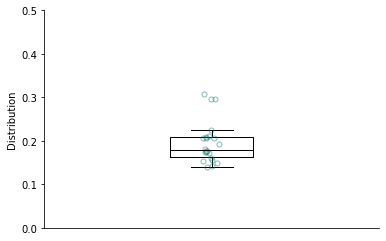

In [13]:
quorum = 40000000

# Calculate the sum of vote weights for each proposal
vote_weights_sum = df.groupby('proposalId')['votesWeight'].sum() # 23 proposals, three proposals didn't reach quorum

# Extract the most influential voter's vote weight for each proposal
most_influential_voters_weight = df.groupby('proposalId')['votesWeight'].max()

# Create a boolean Series indicating if the proposal reached the quorum
reached_quorum = vote_weights_sum >= quorum

# Filter the vote_weights_sum and most_influential_voters_weight Series based on the reached_quorum Series
filtered_vote_weights_sum = vote_weights_sum[reached_quorum]
filtered_most_influential_voters_weight = most_influential_voters_weight[reached_quorum]

# Calculate the voting power share of the most influential voter for the filtered data
filtered_most_influential_voters_share = filtered_most_influential_voters_weight / filtered_vote_weights_sum

# Round the values to 6 decimal places and convert them to float for plotting
filtered_most_influential_voters_share = filtered_most_influential_voters_share.apply(lambda x: round(float(x), 6))

# Create a figure and axis
fig, ax = plt.subplots()

# Add a small amount of random jitter to the x-axis position of the dots
jitter = np.random.uniform(-0.01, 0.01, size=len(filtered_most_influential_voters_share))

# Calculate the box plot statistics
bp_stats = plt.boxplot(filtered_most_influential_voters_share, vert=True, positions=[1], widths=0.1, medianprops={'color': 'black'}, flierprops={'alpha': 0})

# Get the outlier indices
outlier_indices = bp_stats['fliers'][0].get_data()[1]

# Identify the dots that are considered outliers
outliers = filtered_most_influential_voters_share.isin(outlier_indices)

# Plot the dots inside the box plot
ax.plot(np.array([1] * len(filtered_most_influential_voters_share[~outliers])) + jitter[~outliers],
        filtered_most_influential_voters_share[~outliers], 'o', markersize=5, markerfacecolor='none', markeredgecolor='#117B78', markeredgewidth=1, alpha=0.5)

# Plot the outlier dots with a different color
ax.plot(np.array([1] * len(filtered_most_influential_voters_share[outliers])) + jitter[outliers],
        filtered_most_influential_voters_share[outliers], 'o', markersize=5, markerfacecolor='none', markeredgecolor='#117B78', markeredgewidth=1, alpha=0.5)

# Set the labels and limits
ax.set_ylabel('Distribution')
ax.set_xticks([])
ax.set_xlim(0.8, 1.2)  # Adjust the x-axis limits
ax.set_ylim(0, 0.5)  # Adjust the y-axis limits

# Remove the upper and right lines of the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot as PDF
plt.savefig('data/whale_analysis.pdf', bbox_inches='tight')

# Show the plot
plt.show()

## Delegated Voting Power Distribution
Analyzing Voting Power in Decentralized Governance: Who controls DAOs?, Fritsch et al., 2022

In [14]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('data/Uniswap_UNITOKEN_delegates_balance.csv')

# Convert 'votingPower' to Decimal
df_raw['votingPower'] = df_raw['votingPower'].apply(Decimal)

# Convert 'votingPower' to a human-readable format (base unit)
df_raw['votingPower'] = df_raw['votingPower'].apply(lambda x: x / Decimal(10 ** 18))

# Create a new DataFrame from the filtered data
df = df_raw.copy()

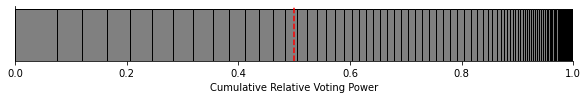

In [15]:
# Calculate the relative voting power for each address
relative_voting_power = df['votingPower'] / df['votingPower'].sum()

# Calculate the cumulative sum of the relative voting power
cumulative_relative_voting_power = np.insert(relative_voting_power.cumsum().values, 0, 0)[:-1]

# Convert these arrays to float type
cumulative_relative_voting_power_float = cumulative_relative_voting_power.astype(float)
relative_voting_power_float = relative_voting_power.values.astype(float)

# Define the colors for the bars
colors = ['gray'] * len(relative_voting_power)

# Plot the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 1))
ax.bar(x=cumulative_relative_voting_power_float,
       width=relative_voting_power_float,
       bottom=0,
       height=0.5,
       color=colors,
       edgecolor='black',
       linewidth=1,
       align='edge')

# Set the labels and title
ax.set_xlabel('Cumulative Relative Voting Power')

# Remove y-axis ticks and labels
ax.set_yticks([])

# Set the x-axis limits to 0-100%
ax.set_xlim(0, 1)

# Remove the upper and right lines of the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a red vertical line at 0.5
ax.axvline(x=0.5, color='red', linestyle='--')

# Save SVG
plt.savefig('plots/vp_distribution.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [16]:
# Convert 'votingPower' to float
df['votingPower'] = df['votingPower'].astype(float)

sum_protocol = df['votingPower'].sum()
print(f"Total delegated tokens {sum_protocol}")

# Calculate the number of delegates that could control the whole protocol
sum_14_largest = df['votingPower'].nlargest(14).sum()
print(f"14 Delegates could control the whole protocol, approx. {sum_14_largest}")

# Calculate the number of delegates that could pass quorum
sum_5_largest = df['votingPower'].nlargest(5).sum()
print(f"5 Delegates could pass quorum, and control protocol if others are not aware, approx {sum_5_largest}")

Total delegated tokens 199605238.59409213
14 Delegates could control the whole protocol, approx. 100758286.91484636
5 Delegates could pass quorum, and control protocol if others are not aware, approx 48901631.67514434


## Delegated Voting Power Distribution (2)


In [17]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('data/Uniswap_UNITOKEN_delegates_balance.csv')

# Convert 'votingPower' to Decimal
df_raw['votingPower'] = df_raw['votingPower'].apply(Decimal)

# Convert 'votingPower' to a human-readable format (base unit)
df_raw['votingPower'] = df_raw['votingPower'].apply(lambda x: x / Decimal(10 ** 18))

# Create a new DataFrame from the filtered data
df = df_raw.copy()

quorum = 40000000000000000000000000  # quorum value
quorum_base_unit = quorum / (10 ** 18)  # convert quorum to base unit
log_quorum = np.log10(float(quorum_base_unit))

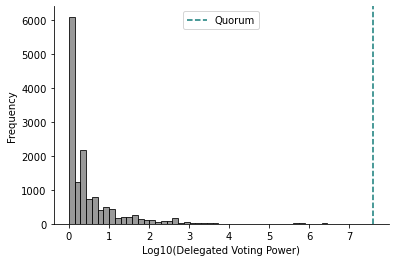

In [18]:
# Apply logarithmic transformation to the voting power values
log_voting_power = np.log10(df['votingPower'])

# Create a histogram to visualize the distribution of the log-transformed median voting weights
fig, ax = plt.subplots()
plt.hist(log_voting_power, bins=50, color='gray', edgecolor='black', alpha=0.8)

# Insert a vertical line at the quorum
plt.axvline(log_quorum, color='#117B78', linestyle='--', label='Quorum')
plt.legend(loc='upper center')

# Set the labels and limits
ax.set_xlabel('Log10(Delegated Voting Power)')
ax.set_ylabel('Frequency')

# Remove the upper and right lines of the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot as PDF
plt.savefig('plots/log_vp_distribution.pdf', bbox_inches='tight')

# Show the plot
plt.show()

## Delegates Analysis

#### Delegate Engagement: How active are delegates in voting?

In [19]:
# Participation rate of top addresses

# Read the CSV file of Uniswap Governor Bravo Proposals
df_raw = pd.read_csv("./data/Uniswap_GOVERNORBRAVO_proposals.csv")

# Convert the 'votesWeight' column to Decimal
df_raw['votesWeight'] = df_raw['votesWeight'].apply(Decimal)

# Convert the 'votesWeight' column to a human-readable format (base unit)
df_raw['votesWeight'] = df_raw['votesWeight'].apply(lambda x: x / (10 ** 18))

# Filter out rows with votesWeight equal to zero
df_filtered = df_raw[df_raw['votesWeight'] > 0]

# Create a new DataFrame from the filtered data
df = df_filtered.copy()

In [20]:
quorum = 40000000

# Calculate the sum of vote weights for each proposal
vote_weights_sum = df.groupby('proposalId')['votesWeight'].sum() # 23 proposals, three proposals didn't reach quorum

# Create a boolean Series indicating if the proposal reached the quorum
reached_quorum = vote_weights_sum >= quorum

# Filter the vote_weights_sum
filtered_vote_weights_sum = vote_weights_sum[reached_quorum]

# Convert filtered_vote_weights_sum index to a list
filtered_proposal_ids = filtered_vote_weights_sum.index.tolist()

# Filter df to contain only the proposals in filtered_proposal_ids
df_filtered = df[df['proposalId'].isin(filtered_proposal_ids)]

# Function to extract voter address from votesId
def extract_voter_address(votesId):
    return votesId.split('|')[1].split(':')[-1]

df_filtered = df_filtered.copy()

# Create a new column 'voter_address' by applying the function to the 'votesId' column
df_filtered.loc[:, 'voter_address'] = df['votesId'].apply(extract_voter_address)

In [21]:
top_delegates_participation = {}
up_delegates_participation = {}
middle_delegates_participation = {}
low_delegates_participation = {}

for address in top_delegates['address']:
    votes = df_filtered[df_filtered['voter_address'] == address]['proposalId'].nunique()
    top_delegates_participation[address] = votes
    
for address in up_delegates['address']:
    votes = df_filtered[df_filtered['voter_address'] == address]['proposalId'].nunique()
    up_delegates_participation[address] = votes
    
for address in middle_delegates['address']:
    votes = df_filtered[df_filtered['voter_address'] == address]['proposalId'].nunique()
    middle_delegates_participation[address] = votes
    
for address in low_delegates['address']:
    votes = df_filtered[df_filtered['voter_address'] == address]['proposalId'].nunique()
    low_delegates_participation[address] = votes
    

# Convert the dictionary to DataFrame
top_delegates_participation_df = pd.DataFrame.from_dict(top_delegates_participation, orient='index', columns=['Number_of_votes'])
top_up_participation_df = pd.DataFrame.from_dict(up_delegates_participation, orient='index', columns=['Number_of_votes'])
top_middle_participation_df = pd.DataFrame.from_dict(middle_delegates_participation, orient='index', columns=['Number_of_votes'])
top_low_participation_df = pd.DataFrame.from_dict(low_delegates_participation, orient='index', columns=['Number_of_votes'])


# Calculate total number of proposals
total_proposals = df['proposalId'].nunique()

# Calculate the participation rate and add it as a new column
top_delegates_participation_df['participation_rate'] = top_delegates_participation_df['Number_of_votes'] / total_proposals
top_up_participation_df['participation_rate'] = top_up_participation_df['Number_of_votes'] / total_proposals
top_middle_participation_df['participation_rate'] = top_middle_participation_df['Number_of_votes'] / total_proposals
top_low_participation_df['participation_rate'] = top_low_participation_df['Number_of_votes'] / total_proposals


mean_participation_rate = top_delegates_participation_df['participation_rate'].mean()
mean_up_participation_rate = top_up_participation_df['participation_rate'].mean()
mean_middle_participation_rate = top_middle_participation_df['participation_rate'].mean()
mean_low_participation_rate = top_low_participation_df['participation_rate'].mean()


print("Mean all top delegates: ", mean_participation_rate)
print("Mean up top delegates: ", mean_up_participation_rate)
print("Mean middle top delegates: ", mean_middle_participation_rate)
print("Mean low top delegates: ", mean_low_participation_rate)
print(len(top_delegates))

Mean all top delegates:  0.24181818181818174
Mean up top delegates:  0.28
Mean middle top delegates:  0.3400000000000001
Mean low top delegates:  0.08285714285714287
44


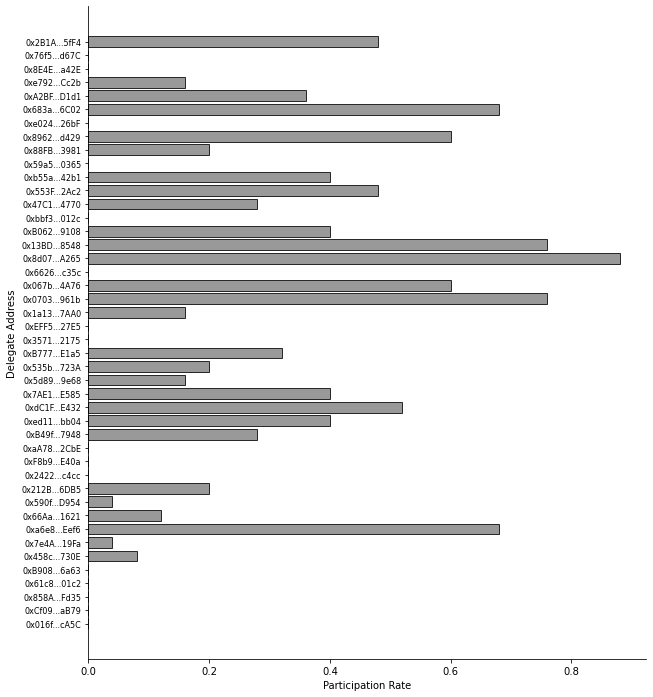

In [22]:
formatted_addresses = [address[:6] + '...' + address[-4:] for address in top_delegates_participation_df.index]

plt.figure(figsize=(10, 12))  # Increase the figure size for better visibility
plt.barh(formatted_addresses, top_delegates_participation_df['participation_rate'], color='gray', edgecolor='black', alpha=0.8)

plt.xlabel('Participation Rate')
plt.ylabel('Delegate Address')
# plt.title('Participation Rate of Top Delegates')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Increase y-axis spacing
plt.yticks(fontsize=8)

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

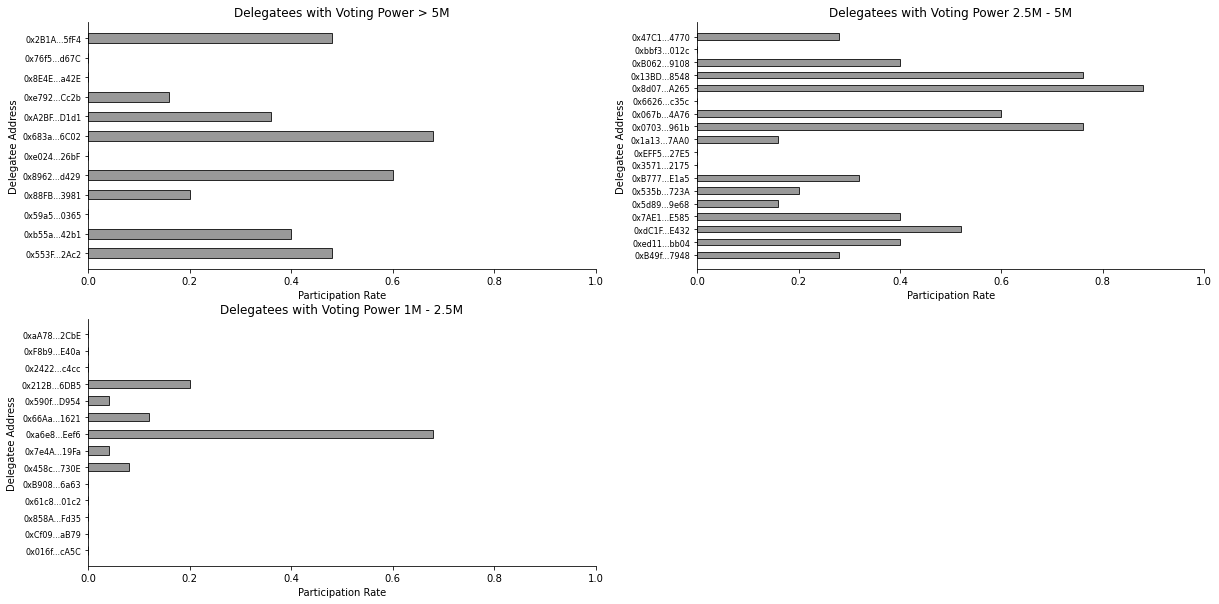

In [26]:
# Define a function to make the subplot
def make_subplot(ax, df, title):
    formatted_addresses = [address[:6] + '...' + address[-4:] for address in df.index]
    ax.barh(formatted_addresses, df['participation_rate'], color='gray', edgecolor='black', alpha=0.8, height=0.5)

    ax.set_xlabel('Participation Rate')
    ax.set_ylabel('Delegatee Address')
    ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim([0, 1])  # Set the limits of the x-axis to [0, 1]

    # Increase y-axis spacing
    ax.tick_params(axis='y', labelsize=8)

    # Invert y-axis
    ax.invert_yaxis()

# Create figure and axes
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Make plots
make_subplot(ax[0][0], top_up_participation_df, 'Delegatees with Voting Power > 5M')
make_subplot(ax[0][1], top_middle_participation_df, 'Delegatees with Voting Power 2.5M - 5M')
make_subplot(ax[1][0], top_low_participation_df, 'Delegatees with Voting Power 1M - 2.5M')

# Remove the last subplot
ax[1][1].remove()

# Improve layout
plt.savefig('plots/participation_rates.pdf', bbox_inches='tight')
plt.show()

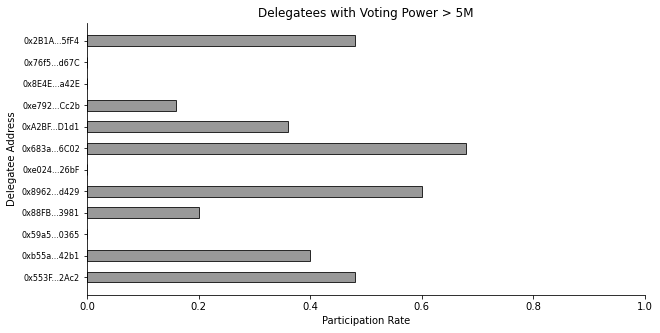

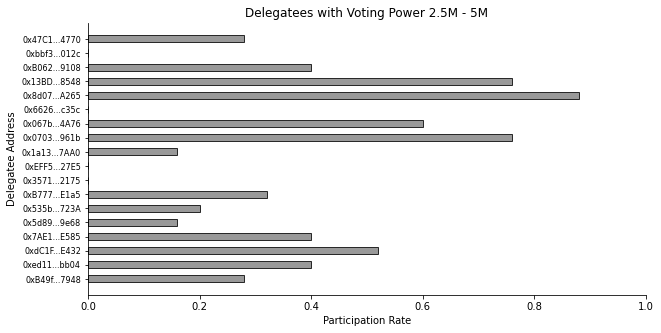

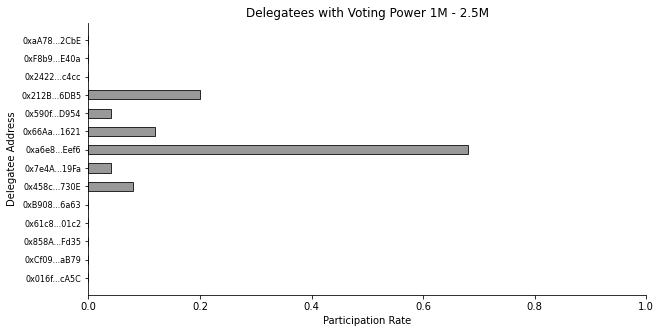

In [25]:
# Create figure and axes for the first plot
fig1, ax1 = plt.subplots(figsize=(10, 5))
make_subplot(ax1, top_up_participation_df, 'Delegatees with Voting Power > 5M')
plt.savefig('plots/top_up_participation_rate.pdf', bbox_inches='tight')
plt.show()

# Create figure and axes for the second plot
fig2, ax2 = plt.subplots(figsize=(10, 5))
make_subplot(ax2, top_middle_participation_df, 'Delegatees with Voting Power  2.5M - 5M')
plt.savefig('plots/top_middle_participation_rate.pdf', bbox_inches='tight')
plt.show()

# Create figure and axes for the third plot
fig3, ax3 = plt.subplots(figsize=(10, 5))
make_subplot(ax3, top_low_participation_df, 'Delegatees with Voting Power 1M - 2.5M')
plt.savefig('plots/top_low_participation_rate.pdf', bbox_inches='tight')
plt.show()

## Delegation Behaviour

In [ ]:
# Are token holders frequently changing their delegated voting representatives? Does it matter?
# Look how many people delegated how much - would be intersting to know if there is a "whale" in the delegation process

In [5]:
#### Delegation Behaviour: How is the delegated voting changing over time considering the proposals

In [28]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('data/delegatees_events/Uniswap_UNITOKEN_delegate_events_1.csv')
address_of_interest = '0x2B1Ad6184a6B0fac06bD225ed37C2AbC04415fF4' # do it for the 8 delegatees (> 5 Mil + Participation Rate > 0)
"""
0x2B1Ad6184a6B0fac06bD225ed37C2AbC04415fF4 0x2B1A...5fF4 1
0xe7925D190aea9279400cD9a005E33CEB9389Cc2b 0xe792...Cc2b 4
0xA2BF1B0a7E079767B4701b5a1D9D5700eB42D1d1 0xA2BF...D1d1 5
0x683a4F9915D6216f73d6Df50151725036bD26C02 0x683a...6C02 6
0x8962285fAac45a7CBc75380c484523Bb7c32d429 0x8962...d429 8
0x88FB3D509fC49B515BFEb04e23f53ba339563981 0x88FB...3981 9
0x553F674dD7D102ad79C644103974a1cc53b62Ac2 0x553F...2Ac2 11
0x47C125DEe6898b6CB2379bCBaFC823Ff3f614770 0x47C1...4770 12
"""

df_raw['newBalance'] = df_raw['newBalance'].astype(float) / 1e18
df_raw['blockNumber'] = df_raw['blockNumber'].astype(int)

# Create a new DataFrame from the filtered data
df_events = df_raw.copy()

In [29]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('data/delegatees_tally/Uniswap_UNITOKEN_delegate_tally_1.csv')

# Convert voting_power to float
df_raw['voting_power'] = df_raw['voting_power'].astype(float)

# Remove rows where voting_power is 0
df_raw = df_raw[df_raw['voting_power'] > 0]

# Create a new DataFrame from the filtered data
df_tally = df_raw.copy()

In [30]:
# Read the CSV file of Uniswap Governor Bravo Proposals
df_raw = pd.read_csv("./data/Uniswap_GOVERNORBRAVO_proposals.csv")

# Convert the 'votesWeight' column to Decimal
df_raw['votesWeight'] = df_raw['votesWeight'].apply(Decimal)

# Convert the 'votesWeight' column to a human-readable format (base unit)
df_raw['votesWeight'] = df_raw['votesWeight'].apply(lambda x: x / (10 ** 18))

# Filter out rows with votesWeight equal to zero
df_filtered = df_raw[df_raw['votesWeight'] > 0]

# Create a new DataFrame from the filtered data
df_proposals = df_filtered.copy()

quorum = 40000000

# Calculate the sum of vote weights for each proposal
vote_weights_sum = df_proposals.groupby('proposalId')['votesWeight'].sum() # 23 proposals, three proposals didn't reach quorum

# Create a boolean Series indicating if the proposal reached the quorum
reached_quorum = vote_weights_sum >= quorum

# Filter the vote_weights_sum
filtered_vote_weights_sum = vote_weights_sum[reached_quorum]

# Convert filtered_vote_weights_sum index to a list
filtered_proposal_ids = filtered_vote_weights_sum.index.tolist()

# Filter df to contain only the proposals in filtered_proposal_ids
df_filtered = df_proposals[df_proposals['proposalId'].isin(filtered_proposal_ids)]

# Function to extract voter address from votesId
def extract_voter_address(votesId):
    return votesId.split('|')[1].split(':')[-1]

df_filtered = df_filtered.copy()

# Create a new column 'voter_address' by applying the function to the 'votesId' column
df_filtered.loc[:, 'voter_address'] = df_proposals['votesId'].apply(extract_voter_address)

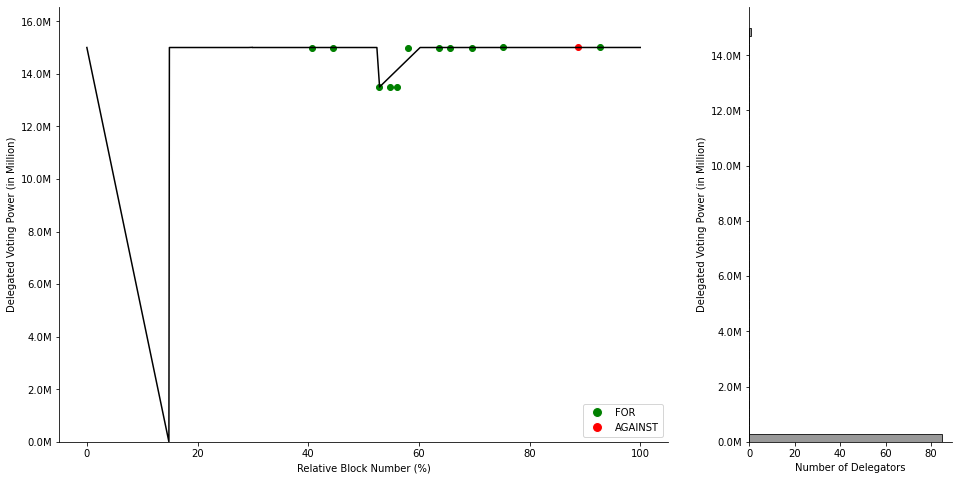

In [31]:
# Define the function that will format the y-axis values
def millions(x, pos):
    'The two args are the value and tick position'
    return '{:.1f}M'.format(x*1e-6)

# Filter out rows where the voter_address is the address of interest
df_filtered_address = df_filtered[df_filtered['voter_address'] == address_of_interest]

df_events['relativeBlock'] = ((df_events['blockNumber'] - df_events['blockNumber'].min()) / 
                              (df_events['blockNumber'].max() - df_events['blockNumber'].min())) * 100

# Extract block numbers where proposals were voted on with 'FOR' and 'AGAINST' votes
voted_for_proposal_blocks = df_filtered_address[df_filtered_address['votesSupport'] == 'FOR']['proposalEndBlock'].unique()
voted_against_proposal_blocks = df_filtered_address[df_filtered_address['votesSupport'] == 'AGAINST']['proposalEndBlock'].unique()

# Calculate relative proposal block numbers
voted_for_proposal_blocks_relative = ((voted_for_proposal_blocks - df_events['blockNumber'].min()) /
                                      (df_events['blockNumber'].max() - df_events['blockNumber'].min())) * 100

voted_against_proposal_blocks_relative = ((voted_against_proposal_blocks - df_events['blockNumber'].min()) /
                                          (df_events['blockNumber'].max() - df_events['blockNumber'].min())) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1]})

# Plot delegated voting power over relative block number
ax1.plot(df_events['relativeBlock'], df_events['newBalance'], label='Delegated Voting Power', color='black')

# Add green dots for when proposals were voted on with 'FOR' votes
for block in voted_for_proposal_blocks_relative:
    nearest_block = df_events['relativeBlock'].sub(block).abs().idxmin()
    power_at_block = df_events.loc[nearest_block, 'newBalance']
    ax1.scatter(block, power_at_block, color='green', label='FOR Votes')  # Change color as needed

# Add red dots for when proposals were voted on with 'AGAINST' votes
for block in voted_against_proposal_blocks_relative:
    nearest_block = df_events['relativeBlock'].sub(block).abs().idxmin()
    power_at_block = df_events.loc[nearest_block, 'newBalance']
    ax1.scatter(block, power_at_block, color='red', label='AGAINST Votes')  # Change color as needed

# Create the formatter
formatter = FuncFormatter(millions)

ax1.set_xlabel('Relative Block Number (%)')
ax1.set_ylabel('Delegated Voting Power (in Million)')
ax1.set_ylim(bottom=0)  # Set the lower limit of y-axis to 0

# Apply the formatter to the y-axis
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='FOR'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='AGAINST')]

ax1.legend(handles=legend_elements, loc='lower right')
# ax1.set_title('Temporal Progression of Delegated Voting Power with Proposal Participation for Address 0x2B1A...5fF4')
ymin, ymax = ax1.get_ylim()
ax1.set_ylim(ymin, ymax * 1.05)


# Histogram
ax2.hist(df_tally['voting_power'], bins=50, color='gray', edgecolor='black', alpha=0.8, orientation='horizontal')
ax2.set_xlabel('Number of Delegators')
ax2.set_ylabel('Delegated Voting Power (in Million)')
ax2.set_ylim(bottom=0)  # Set the lower limit of y-axis to 0
# ax2.set_title('Distribution of Delegated Voting Power')

plt.savefig('plots/01_progression.pdf', bbox_inches='tight')
plt.show()

## Previous Code / Not Considered

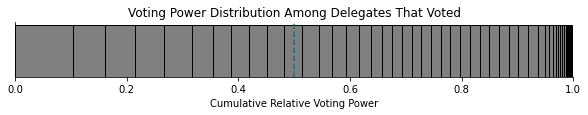

73770506.13772672
45433774.79567039


In [292]:
# OLD: Approximation with voting weights mean used in proposals
# approx. because of median (problems with api)

# Sort the addresses by median voting weight in descending order
sorted_median_voting_weight = median_voting_weight.sort_values(ascending=False)

# Calculate the relative voting power for each address
relative_voting_power = sorted_median_voting_weight / sorted_median_voting_weight.sum()

# Sort the relative voting power in descending order
sorted_relative_voting_power = relative_voting_power.sort_values(ascending=False)

# Calculate the cumulative sum of the relative voting power
cumulative_relative_voting_power = np.insert(sorted_relative_voting_power.cumsum().values, 0, 0)[:-1]

# Define the colors for the bars
colors = ['gray'] * len(sorted_relative_voting_power)

# Plot the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 1))
ax.bar(x=cumulative_relative_voting_power,
       width=sorted_relative_voting_power,
       bottom=0,
       height=0.5,
       color=colors,
       edgecolor='black',
       linewidth=1,
       align='edge')

# Set the labels and title
ax.set_xlabel('Cumulative Relative Voting Power')
ax.set_title('Voting Power Distribution Among Delegates That Voted')

# Remove y-axis ticks and labels
ax.set_yticks([])

# Set the x-axis limits to 0-100%
ax.set_xlim(0, 1)

# Remove the upper and right lines of the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a red vertical line at 0.5
ax.axvline(x=0.5, color='#117B78', linestyle='--')

# Save SVG
plt.savefig('distribution.svg', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Nakamoto Delegates: 11
# Gini: approx. 0.97

sum_11_largest = sorted_median_voting_weight.nlargest(11).sum()
print(sum_11_largest) # 11 Delegates could control the whole protocol, approx. 73 Mil

sum_5_largest = sorted_median_voting_weight.nlargest(5).sum()
print(sum_5_largest) # 5 Delegates could pass quorum, and control protocol if others are not aware, approx 45 Mil

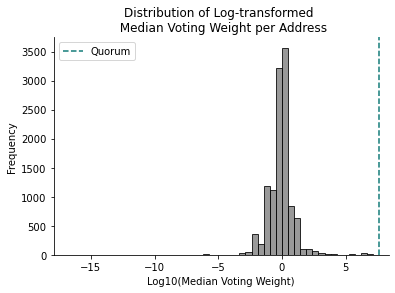

In [270]:
# OLD: Approximation with voting weights mean used in proposals
# Create distribution of voting weights

# Function to extract voter address from votesId
def extract_voter_address(votesId):
    return votesId.split('|')[1].split(':')[-1]

quorum = 40000000000000000000000000  # quorum value
quorum_base_unit = quorum / (10 ** 18)  # convert quorum to base unit
log_quorum = np.log10(float(quorum_base_unit))

# Create a new column 'voter_address' by applying the function to the 'votesId' column
df.loc[:, 'voter_address'] = df['votesId'].apply(extract_voter_address)

# Group the filtered data by voter address and calculate the median voting weight for each address
median_voting_weight = df.groupby('voter_address')['votesWeight'].median()

# Apply logarithmic transformation to the median_voting_weight values
log_median_voting_weight = np.log10(median_voting_weight)

# Create a histogram to visualize the distribution of the log-transformed median voting weights
fig, ax = plt.subplots()
plt.hist(log_median_voting_weight, bins=50, color='gray', edgecolor='black', alpha=0.8)

# Insert a vertical line at the quorum
plt.axvline(log_quorum, color='#117B78', linestyle='--', label='Quorum')
plt.legend()

# Set the labels and limits
ax.set_xlabel('Log10(Median Voting Weight)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Log-transformed \n Median Voting Weight per Address')

# Remove the upper and right lines of the graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot as a SVG image with a DPI of 300
plt.savefig('log_distribution_voting_weight_per_address.svg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

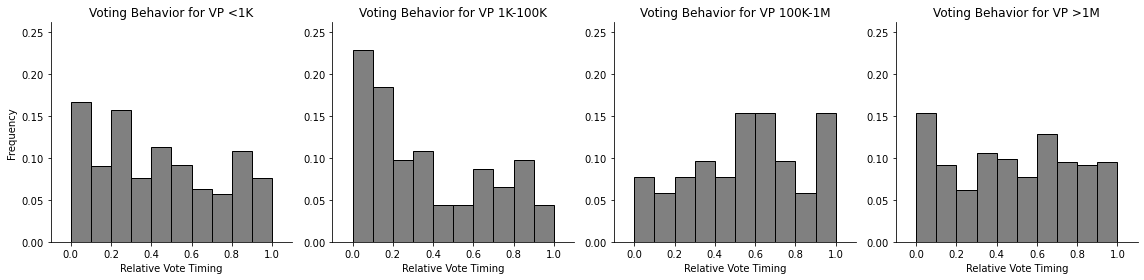

In [290]:
# RVT (Goldberg & Schär)

# Function to calculate the Relative Vote Timing (RVT)
def calculate_rvt(vote_timestamp, start_timestamp, end_timestamp):
    return (vote_timestamp - start_timestamp) / (end_timestamp - start_timestamp)

# Convert the timestamps to datetime objects
df['votesTimestamp'] = pd.to_datetime(df['votesTimestamp'])
df['proposalStart'] = pd.to_datetime(df['proposalStart'])
df['proposalEnd'] = pd.to_datetime(df['proposalEnd'])

# Calculate the RVT for each vote
df['RVT'] = df.apply(lambda row: calculate_rvt(row['votesTimestamp'], row['proposalStart'], row['proposalEnd']), axis=1)

# Define the thresholds for the groups
thresholds = [0, 1000, 100000, 1000000,  float('inf')]

# Define the labels for the groups
group_labels = ['<1K', '1K-100K', '100K-1M', '>1M']

# Create a new column 'group' in the DataFrame using the thresholds and labels
df['group'] = pd.cut(df['votesWeight'], bins=thresholds, labels=group_labels)

def plot_rvt_by_group(df):
    # Define the bins for the histogram
    bins = [i / 10 for i in range(11)]
    bar_width = 0.1  # No gaps between bars

    # Get the list of unique groups
    unique_groups = df['group'].unique()
    
     # Sort the unique_groups based on group_labels
    unique_groups = sorted(unique_groups, key=lambda x: group_labels.index(x))

    # Create subplots for the bar charts
    num_groups = len(unique_groups)
    fig, axes = plt.subplots(1, num_groups, figsize=(4 * num_groups, 4), sharey=True)

    # Loop through the unique groups and plot the RVT histogram for each group
    for i, group in enumerate(unique_groups):
        group_data = df[df['group'] == group]
        rvt_counts, _ = np.histogram(group_data["RVT"], bins=bins)
        rvt_freq = rvt_counts / sum(rvt_counts)

        axes[i].bar(bins[:-1], rvt_freq, width=bar_width, align='edge', color='gray', edgecolor='black')
        axes[i].set_xlabel('Relative Vote Timing')
        axes[i].set_title(f'Voting Behavior for VP {group}')

        # Set y-axis label only for the first subplot
        if i == 0:
            axes[i].set_ylabel('Frequency')
            
        # Enable y-axis tick labels for all subplots
        axes[i].yaxis.set_tick_params(which='both', labelleft=True)

        # Set x-axis and y-axis limits
        axes[i].set_xlim(-0.1, 1.1)
        axes[i].set_ylim(0, max(rvt_freq) * 1.7)

        # Remove the upper and right lines of the graph
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

    # Display the plots
    plt.tight_layout()
    # Save the plot as a SVG image with a DPI of 300
    plt.savefig('rtv.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function with the DataFrame
plot_rvt_by_group(df)